In [1]:
from pathlib import Path

import jupyter_black
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from hydra import compose
from hydra import initialize
from hydra.core.global_hydra import GlobalHydra

jupyter_black.load()
# plt.style.use("ggplot")
sns.set()

EXP_NAME = "exp075"
RUN_NAME = "single"
RESULT_DIR = Path("../output/train") / EXP_NAME / RUN_NAME


def load_config(result_dir: Path):
    # clear previous initialization
    GlobalHydra.instance().clear()

    # initialize hydra
    config_path = result_dir / ".hydra"
    initialize(config_path=config_path.as_posix())
    # load the config
    cfg = compose(config_name="config")

    return cfg

In [2]:
cfg = load_config(RESULT_DIR)
# cfg.dir.data_dir = (
#     "/home/kuto/kaggle/kaggle-sleep-v2/data/child-mind-institute-detect-sleep-states"
# )
preds = np.load(RESULT_DIR / "preds.npy")
labels = np.load(RESULT_DIR / "labels.npy")
keys = np.load(RESULT_DIR / "keys.npy")

gt_df = pd.read_csv(Path(cfg.dir.data_dir) / "train_events.csv")
gt_df = gt_df[gt_df["series_id"].isin(cfg.split.valid_series_ids)].dropna().reset_index(drop=True)

/tmp/ipykernel_907896/296831329.py:32: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  initialize(config_path=config_path.as_posix())


In [3]:
def min_max_normalize(x):
    return (x - x.min()) / (x.max() - x.min())

In [4]:
# preds[:, :, 0] = min_max_normalize(preds[:, :, 0])
# preds[:, :, 1] = min_max_normalize(preds[:, :, 1])
# preds[:, :, 2] = min_max_normalize(preds[:, :, 2])

In [7]:
def plot_random_sample(keys, preds, labels, num_samples=1, num_chunks=10):
    # get series ids
    series_ids = np.array(list(map(lambda x: x.split("_")[0], keys)))
    unique_series_ids = np.unique(series_ids)

    # get random series
    # random_series_ids = np.random.choice(unique_series_ids, num_samples)
    random_series_ids = ["f56824b503a0"]

    for i, random_series_id in enumerate(random_series_ids):
        # get random series
        series_idx = np.where(series_ids == random_series_id)[0]
        this_series_preds = preds[series_idx].reshape(-1, 3)
        this_series_labels = labels[series_idx].reshape(-1, 3)

        # split series
        this_series_preds = np.split(this_series_preds, num_chunks)
        this_series_labels = np.split(this_series_labels, num_chunks)

        fig, axs = plt.subplots(num_chunks, 1, figsize=(20, 3 * num_chunks))
        if num_chunks == 1:
            axs = [axs]
        for j in range(num_chunks):
            this_series_preds_chunk = this_series_preds[j]
            this_series_labels_chunk = this_series_labels[j]

            # get onset and wakeup idx
            onset_idx = np.nonzero(this_series_labels_chunk[:, 1])[0]
            wakeup_idx = np.nonzero(this_series_labels_chunk[:, 2])[0]

            axs[j].plot(this_series_preds_chunk[:, 0], label="pred_sleep")
            axs[j].plot(this_series_preds_chunk[:, 1], label="pred_onset")
            axs[j].plot(this_series_preds_chunk[:, 2], label="pred_wakeup")
            axs[j].vlines(onset_idx, 0, 1, label="gt_onset", linestyles="dashed", color="C1")
            axs[j].vlines(wakeup_idx, 0, 1, label="gt_wakeup", linestyles="dashed", color="C2")
            axs[j].set_ylim(-0.1, 1.1)
            axs[j].set_title(f"series_id: {random_series_id} chunk_id: {j}")
            axs[j].legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0)

    plt.tight_layout()

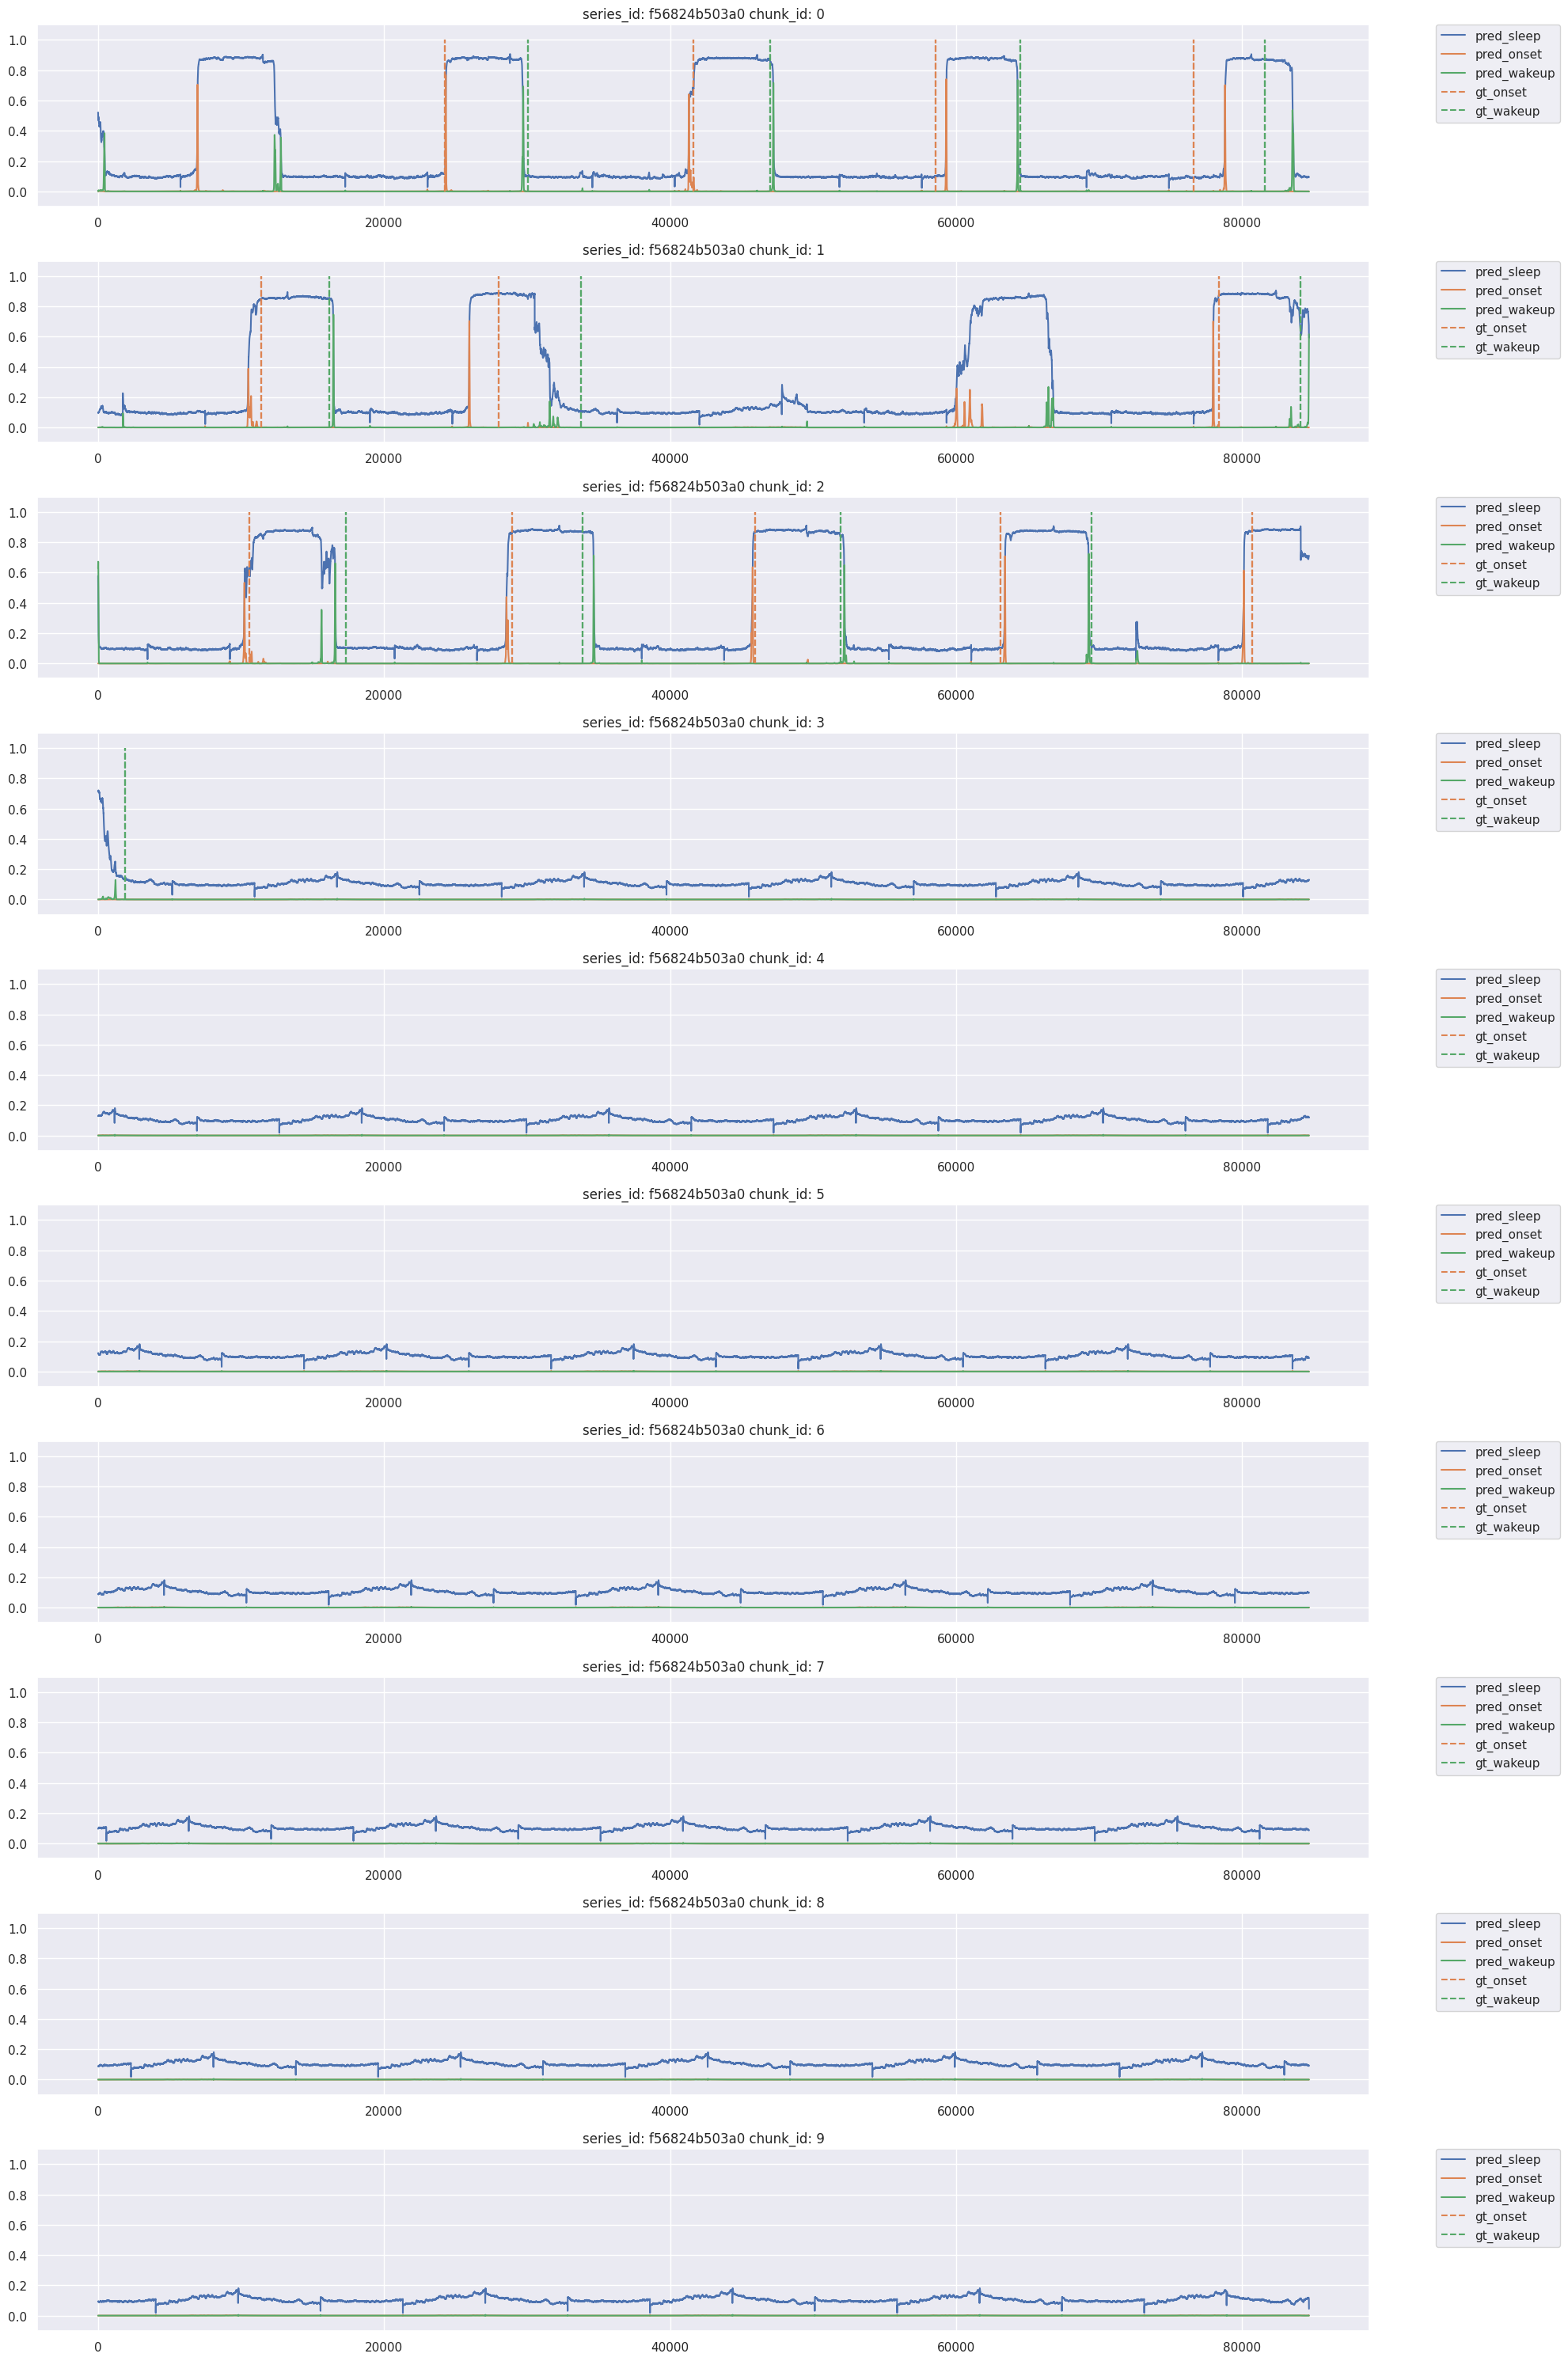

In [9]:
plot_random_sample(keys, preds, labels, num_samples=1, num_chunks=10)